<a href="https://colab.research.google.com/github/danmenloz/LeafWilting/blob/main/DanielCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import collections
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import pandas as pd
import cv2
from PIL import Image
import os
from math import ceil
 
import keras
from keras.models import Model
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras import regularizers
from keras.optimizers import SGD, Adam, RMSprop
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
 
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import class_weight

In [2]:
def loadImages(path):
    # list with paths of all images in the folder
    f_paths = sorted([os.path.join(path, file)
                          for file in os.listdir(path)
                          if file.endswith('.jpg')])
    # list with file names of the images
    f_names = [ os.path.basename(i) for i in f_paths ]
    # list with images
    # images = [ cv2.imread(i, cv2.IMREAD_UNCHANGED) for i in files_path ] # cv read takes too long!
    images = [ plt.imread(i) for i in f_paths ]

    return f_names, images


def loadAnnotations(path):
  table = pd.read_csv(path)
  # file_names = list(table[['file_name']])
  f_names = [x[0] for x in table.values] #read colum 0
  annotations = np.asarray(table[['annotation']]).ravel()
  return f_names, annotations
 

def buildDataset(f_names, annotations, img_names, images):
  img_set = [] # empty list
  for i in range(len(f_names)):
    img_dict = {} # empty dictionary
    try:
      # find image name in annotation file
      idx = f_names.index(img_names[i])
      # create dictionary and add it to the list
      img_dict['file_name'] = f_names[i]
      img_dict['annotation'] = annotations[i]
      img_dict['image'] = images[i]
      img_set.append(img_dict)
    except:
      print("Image " + img_names[i] + " not found in annotations file!")
  
  return img_set


def reduceImages(images, imgNewSz):
  #Reduce the images by pixel size
  reduced_images = []
  for i in images:
    rimg = cv2.resize(i, (imgNewSz,imgNewSz), interpolation = cv2.INTER_AREA)
    # rimg = cv2.resize(i, None, fx=ratio, fy=ratio, interpolation = cv2.INTER_AREA)
    reduced_images.append(rimg)

  reduced_images = np.array(reduced_images)
  return reduced_images


# Histogram equalization
# https://stackoverflow.com/questions/31998428/opencv-python-equalizehist-colored-image
def histEqualization(dataset):
  equ_dataset = dataset # copy input dataset
  for n in range(len(dataset)):
    # convert to YUV
    img_yuv = cv2.cvtColor(dataset[n]['image'], cv2.COLOR_BGR2YUV)
    # equalize the histogram of the Y channel
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    # convert the YUV image back to RGB format
    equ_dataset[n]['image']  = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
  return equ_dataset


def countClasses(dataset):
  labels = np.asarray( [d['annotation'] for d in dataset] )
  print("Class 0:", np.sum(labels == 0))
  print("Class 1:", np.sum(labels == 1))
  print("Class 2:", np.sum(labels == 2))
  print("Class 3:", np.sum(labels == 3))
  print("Class 4:", np.sum(labels == 4))
  print(" Total :", len(labels))
  print("") # enter


def countLabels(labels):
  print("Class 0:", np.sum(labels == 0))
  print("Class 1:", np.sum(labels == 1))
  print("Class 2:", np.sum(labels == 2))
  print("Class 3:", np.sum(labels == 3))
  print("Class 4:", np.sum(labels == 4))
  print(" Total :", len(labels))
  print("") # enter

In [3]:
#Access data in Google Drive
from google.colab import drive
drive.mount('/content/drive')
#drive.flush_and_unmount()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Training and validation data generator
datagen = ImageDataGenerator(
  rescale=1./255,
	rotation_range=10,
	# zoom_range=0.15, # [1-zoom_range,1+zoom_range]
	# width_shift_range=0.2,
	# height_shift_range=0.2,
	# shear_range=0.15,
  # brightness_range=[0.4,1.5],
	horizontal_flip=True,
	fill_mode="reflect") #  nearest

# Test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

In [24]:
# datagen

base_path = "drive/My Drive/ECE_542-Project_1/"
datasets_paths = [ os.path.join(base_path,'data/test/'),
                   os.path.join(base_path,'data/train/'),
                   os.path.join(base_path,'data/validation/') ]

img_size = (224,224)
b_size = 32

# load and iterate test dataset
test_it = test_datagen.flow_from_directory(datasets_paths[0],  batch_size=100, target_size=img_size)
# load and iterate training dataset
train_it = datagen.flow_from_directory(datasets_paths[1], batch_size=b_size, target_size=img_size)
# load and iterate validation dataset
val_it = datagen.flow_from_directory(datasets_paths[2],  batch_size=b_size, target_size=img_size)


Found 100 images belonging to 5 classes.
Found 820 images belonging to 5 classes.
Found 355 images belonging to 5 classes.


(32, 224, 224, 3)
(32, 5)


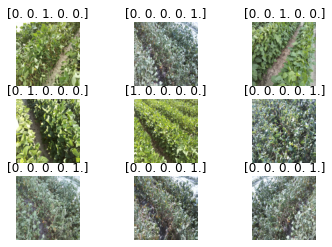

In [6]:
# Plot images from dataset
gen_imgs, gen_lbls = next(train_it)
print(gen_imgs.shape)
print(gen_lbls.shape)

# Plot 9 images
NUM_IMG = 9 
for i, (image, label) in enumerate(zip(gen_imgs,gen_lbls)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image)
  plt.title(str(label))
  plt.axis("off")
  if i >= NUM_IMG-1:
    break

In [7]:
# Class weights 
# See Dataset.ipybn for details of calculation
c_weights = {0: 0.5015290519877675, 
             1: 0.7592592592592593, 
             2: 2.1298701298701297, 
             3: 2.1298701298701297, 
             4: 1.3333333333333333}
print(c_weights)

{0: 0.5015290519877675, 1: 0.7592592592592593, 2: 2.1298701298701297, 3: 2.1298701298701297, 4: 1.3333333333333333}


In [8]:
# # Defining Base CNN Model
# def define_base_model(height, width, rate):
#     model = Sequential()
 
#     model.add(Conv2D(32, (3, 3), activation='relu',  padding='same', input_shape=(height, width, 3)))
#     model.add(Dropout(rate))
#     model.add(MaxPooling2D((2, 2)))
 
#     model.add(Conv2D(64, (3, 3), activation='relu',  padding='same'))
#     model.add(Dropout(rate))
#     model.add(MaxPooling2D((2, 2)))
 
#     #model.add(Conv2D(128, (3, 3), activation='relu',  padding='same'))
#     #model.add(Dropout(rate))
#     #model.add(MaxPooling2D((2, 2)))
 
#     model.add(Flatten())
#     model.add(Dense(256, activation='relu'))
#     model.add(Dropout(rate))
#     model.add(Dense(32, activation='relu'))
#     model.add(Dropout(rate))    
#     model.add(Dense(5, activation='softmax'))
 
#     return model


In [9]:
# Transfer learning

# loading the vgg16 model
from keras.applications.vgg16 import VGG16

# load model and specify a new input shape for images
vgg = VGG16(input_shape=(img_size[0], img_size[1], 3), include_top=True) # True=include FC layers

# Freeze model
for layer in (vgg.layers)[:19]: # Freeze all convolutional layers
    print(layer)
    layer.trainable = False

# Replace vgg output layer
x= vgg.layers[-2].output
prediction = Dense(5, activation="softmax")(x) # 5 classes

# x = Flatten()(vgg.output)
# prediction = Dense(5, activation='softmax')(x) # 5 classes

# Creating instance
model = Model(inputs = vgg.input, outputs = prediction)
model.compile(loss='categorical_crossentropy',
                    optimizer=Adam(),
                    metrics=['categorical_accuracy'])


# summarize the model
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [20]:
# Train the model
train_data = 1000 # number images to generate for training
val_data = int(0.3*train_data) # number images to generate for validation
print("Training images: %d" % (ceil(train_data/b_size)*b_size))
print("Validation images: %d" % (ceil(val_data/b_size)*b_size))

history = model.fit(
    train_it,
    # steps_per_epoch=ceil(train_data/b_size),
    validation_data=val_it,
    # validation_steps=ceil(val_data/b_size),
    epochs = 20,
    class_weight=c_weights, 
    verbose=1)

Training images: 1024
Validation images: 320
Epoch 1/20
26/26 [==============================] - 24s 916ms/step - loss: 0.8786 - categorical_accuracy: 0.6598 - val_loss: 0.5869 - val_categorical_accuracy: 0.7606
Epoch 2/20
26/26 [==============================] - 23s 886ms/step - loss: 0.6193 - categorical_accuracy: 0.7402 - val_loss: 0.6352 - val_categorical_accuracy: 0.7549
Epoch 3/20
26/26 [==============================] - 23s 883ms/step - loss: 0.5652 - categorical_accuracy: 0.7476 - val_loss: 0.7088 - val_categorical_accuracy: 0.7127
Epoch 4/20
26/26 [==============================] - 23s 894ms/step - loss: 0.6058 - categorical_accuracy: 0.7573 - val_loss: 0.8085 - val_categorical_accuracy: 0.7155
Epoch 5/20
26/26 [==============================] - 23s 891ms/step - loss: 0.6603 - categorical_accuracy: 0.7707 - val_loss: 0.5791 - val_categorical_accuracy: 0.7859
Epoch 6/20
26/26 [==============================] - 23s 889ms/step - loss: 0.3814 - categorical_accuracy: 0.8378 - val_l

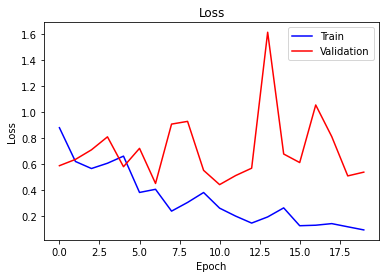

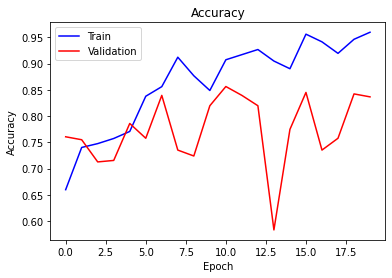

In [21]:
def plot_history(history):
      # plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # plot accuracy
    plt.title('Accuracy')
    plt.plot(history.history['categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_categorical_accuracy'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
 
# Plotting results of training
plot_history(history)

In [12]:
# Fine tunning

# Freeze model
# vgg.trainable = True
# model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
#               loss=keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=[keras.metrics.BinaryAccuracy()])

# model.compile(loss='categorical_crossentropy',
#                     optimizer=Adam(learning_rate=0.00001),
#                     metrics=['categorical_accuracy'])

# history1 = model.fit(trainX, trainY, epochs=5, validation_data=(validX, validY), verbose=1)
# plot_history(history1)

In [23]:
# F1 Score

# load and iterate training dataset
# train_it1 = datagen.flow_from_directory(datasets_paths[1], batch_size=32, target_size=img_size)
# gen_imgs, gen_lbls 

trueY = np.argmax(gen_lbls, axis=1)

# base_results = model.predict_classes(validX) # 'Functional' object has no attribute 'predict_classes'
base_results = model.predict(gen_imgs)
base_results = np.argmax(base_results,axis=1)

base_f1_score = f1_score(trueY, base_results, average=None)
print(base_f1_score)

[1. 1. 1. 1. 1.]


In [25]:
# Test set

# # extract images and labels from dataset
# pre_test_images = [ d['image'] for d in test_dataset ]
# pre_test_labels = [ d['annotation'] for d in test_dataset ]

# # Measure performance on test set
# pre_test_images = reduceImages(pre_test_images, img_size)

pre_test_images, pre_test_labels = next(test_it)
pre_test_labels = np.argmax(pre_test_labels, axis=1)

pre_test_results = model.predict(pre_test_images)
pre_test_results = np.argmax(pre_test_results,axis=1)

print(np.sum(pre_test_results == pre_test_labels)/len(pre_test_labels))
countLabels(pre_test_results)

0.74
Class 0: 26
Class 1: 16
Class 2: 17
Class 3: 26
Class 4: 15
 Total : 100



In [27]:
# F1 Score Test set
trueY = pre_test_labels
test_f1_score = f1_score(trueY, pre_test_results, average=None)
print(test_f1_score)
model.save( os.path.join(base_path,'vgg16_model') )

[0.7826087  0.72222222 0.59459459 0.73913043 0.85714286]
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: drive/My Drive/ECE_542-Project_1/vgg16_model/assets


In [29]:
# Generate CSV
test_path = "/content/drive/My Drive/ECE_542-Project_1/TestData-20201017T151905Z-001.zip"
 
zip1 = zipfile.ZipFile(test_path)
listOfFileNames1 = sorted(zip1.namelist())

# Remove 'Directory name'
file_name = []
for f in listOfFileNames1:
  file_name.append(f.replace('TestData/',''))
# print(file_name)
 
#Create array of test data
test = []
for file in listOfFileNames1:
  if file.endswith('.jpg'):
    img1 = plt.imread(zip1.open(file))
    test.append(img1)
  
test = np.array(test)

test_images = reduceImages(test, img_size[0])
# print(test_images.shape)
test_results = model.predict(test_images)
test_results = np.argmax(test_results,axis=1)

countLabels(test_results)

# Generate CSV file
data = {'file_name': file_name,'annotation': test_results  }
export_data = pd.DataFrame(data, columns=['file_name', 'annotation'])
export_data.to_csv (r'/content/drive/My Drive/ECE_542-Project_1/prediction_vgg16.csv', index = False, header=True)
print(export_data)

Class 0: 138
Class 1: 62
Class 2: 0
Class 3: 0
Class 4: 0
 Total : 200

      file_name  annotation
0    020031.jpg           0
1    020244.jpg           1
2    020446.jpg           0
3    020597.jpg           0
4    020693.jpg           0
..          ...         ...
195  029650.jpg           1
196  029787.jpg           0
197  029841.jpg           0
198  029866.jpg           1
199  029897.jpg           0

[200 rows x 2 columns]
